In [80]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, LayerNormalization
from tensorflow.keras.models import Model
import numpy as np
import re
import tensorflow_datasets as tfds

# Positional Encoding
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model) // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

# Tokenizer dan preprocessing data
def tokenize_and_pad(texts, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences

# Menggunakan tf.keras.preprocessing.text.Tokenizer untuk membuat tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

input_texts = ["This is a test sentence.", "Another example of a sentence."]
target_texts = ["This is a paraphrase example.", "Another test paraphrase."]

# Membuat tokenizer untuk input dan target
input_tokenizer = Tokenizer(num_words=8500, oov_token="<OOV>")
target_tokenizer = Tokenizer(num_words=8000, oov_token="<OOV>")
input_tokenizer.fit_on_texts(input_texts)
target_tokenizer.fit_on_texts(target_texts)

# Menentukan panjang maksimum
max_input_len = max(len(text.split()) for text in input_texts)
max_target_len = max(len(text.split()) for text in target_texts)

# Tokenisasi dan padding
input_sequences = tokenize_and_pad(input_texts, input_tokenizer, max_input_len)
target_sequences = tokenize_and_pad(target_texts, target_tokenizer, max_target_len)

# Menentukan vocab size
input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

# Model Transformer (dari template yang telah diberikan)
# Multi-Head Attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        attention = tf.reshape(attention, (batch_size, -1, self.d_model))
        output = self.dense(attention)
        return output

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

# Feed Forward Network
class PositionwiseFeedforward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super(PositionwiseFeedforward, self).__init__()
        self.d_model = d_model
        self.dff = dff
        self.dense1 = Dense(dff, activation='relu')
        self.dense2 = Dense(d_model)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedforward(d_model, dff)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, x, training, mask):
        attn_output = self.att(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dropout = Dropout(dropout_rate)
        self.enc_layers = [TransformerBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

# Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dropout = Dropout(dropout_rate)
        self.dec_layers = [TransformerBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, training, look_ahead_mask)
        return x

# Transformer Model
class Transformer(Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = Dense(target_vocab_size)

    def call(self, inputs, targets, training, look_ahead_mask, padding_mask):
        enc_output = self.encoder(inputs, training, padding_mask)
        dec_output = self.decoder(targets, enc_output, training, look_ahead_mask, padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output

# Parameter untuk model
num_layers = 4
d_model = 128
num_heads = 8
dff = 512
dropout_rate = 0.1
pe_input = max_input_len
pe_target = max_target_len

# Buat model Transformer
transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, dropout_rate)

# Kompilasi model
transformer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training model
# Pastikan target_sequences diberi label dengan satu langkah ke depan
target_sequences_input = target_sequences[:, :-1]  # target input
target_sequences_output = target_sequences[:, 1:]  # target output

# Melatih model dengan data parafrase
transformer.fit(
    x=[input_sequences, target_sequences_input],
    y=target_sequences_output,
    batch_size=2,
    epochs=10
)

Epoch 1/10


TypeError: missing a required argument: 'targets'

In [82]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, LayerNormalization
from tensorflow.keras.models import Model
import numpy as np

# Positional Encoding
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model) // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

# Multi-Head Attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        attention = tf.reshape(attention, (batch_size, -1, self.d_model))
        output = self.dense(attention)
        return output

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

# Feed Forward Network
class PositionwiseFeedforward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super(PositionwiseFeedforward, self).__init__()
        self.d_model = d_model
        self.dff = dff
        self.dense1 = Dense(dff, activation='relu')
        self.dense2 = Dense(d_model)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedforward(d_model, dff)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, x, training, mask):
        attn_output = self.att(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dropout = Dropout(dropout_rate)
        self.enc_layers = [TransformerBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

# Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dropout = Dropout(dropout_rate)
        self.dec_layers = [TransformerBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, training, look_ahead_mask)
        return x

# Transformer Model
class Transformer(Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = Dense(target_vocab_size)

    def call(self, inputs, targets, training, look_ahead_mask, padding_mask):
        enc_output = self.encoder(inputs, training, padding_mask)
        dec_output = self.decoder(targets, enc_output, training, look_ahead_mask, padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output

# Parameters
num_layers = 4
d_model = 128
num_heads = 8
dff = 512
input_vocab_size = 8500
target_vocab_size = 8000
pe_input = 1000
pe_target = 1000
dropout_rate = 0.1

# Create the Transformer model
transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, dropout_rate)

# Example Input
inputs = tf.random.uniform((64, 50), dtype=tf.int64, minval=0, maxval=input_vocab_size)
targets = tf.random.uniform((64, 50), dtype=tf.int64, minval=0, maxval=target_vocab_size)
look_ahead_mask = None
padding_mask = None

# Forward Pass
output = transformer(inputs, targets, training=True, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)
print(output.shape)  # (64, 50, target_vocab_size)

ValueError: Exception encountered when calling Transformer.call().

[1mOnly input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: True (of type <class 'bool'>)[0m

Arguments received by Transformer.call():
  • inputs=tf.Tensor(shape=(64, 50), dtype=int64)
  • targets=tf.Tensor(shape=(64, 50), dtype=int64)
  • training=True
  • look_ahead_mask=None
  • padding_mask=None

defrizal


In [1]:
import pandas as pd
import numpy as np
import time
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Input, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import random
from nltk.corpus import wordnet
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

In [2]:
# Memuat dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/ID_Quora_Paraphrasing_train.csv'
data = pd.read_csv(file_path)

# Ambil 50% data sebagai sampel
data = data.sample(frac=0.2, random_state=42)

# Preprocessing Dataset
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    text = re.sub(r'\d+', '', text)      # Hapus angka
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi berlebih
    return text

data['clean_article'] = data['question_1'][:50000].apply(preprocess_text)
data['clean_summary'] = data['question_2'][:50000].apply(preprocess_text)

In [3]:
# Tokenisasi dan pembuatan kamus kata
tokenizer_text = tf.keras.preprocessing.text.Tokenizer()
tokenizer_summary = tf.keras.preprocessing.text.Tokenizer()

tokenizer_text.fit_on_texts(data['clean_article'])
tokenizer_summary.fit_on_texts(data['clean_summary'])

text_sequences = tokenizer_text.texts_to_sequences(data['clean_article'])
summary_sequences = tokenizer_summary.texts_to_sequences(data['clean_summary'])

In [4]:
# Padding sequences
max_text_len = 640
max_summary_len = 320

text_sequences = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=max_text_len, padding='post')
summary_sequences = tf.keras.preprocessing.sequence.pad_sequences(summary_sequences, maxlen=max_summary_len, padding='post')

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(text_sequences, summary_sequences, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the number of samples in each dataset
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 16090
Validation samples: 5363
Testing samples: 5364


In [5]:
# Parameters
vocab_size_text = len(tokenizer_text.word_index) + 1
vocab_size_summary = len(tokenizer_summary.word_index) + 1
embedding_dim = 256
units = 512
num_heads = 8

# Positional Encoding function
def positional_encoding(seq_len, dim):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(dim)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
    angles = pos * angle_rates
    return np.concatenate([np.sin(angles[:, 0::2]), np.cos(angles[:, 1::2])], axis=-1)

In [6]:
def transformer_block(inputs, num_heads, ff_units):
    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=units)(inputs, inputs)
    attention_output = Dropout(0.3)(attention_output)
    attention_output = LayerNormalization()(inputs + attention_output)  # Add & Normalize

    # Feed Forward Layer
    ff_output = Dense(ff_units, activation='relu')(attention_output)
    ff_output = Dropout(0.3)(ff_output)
    ff_output = Dense(units)(ff_output)  # Ensure consistency in output dimension

    if attention_output.shape[-1] != ff_output.shape[-1]:
        ff_output = Dense(attention_output.shape[-1])(ff_output)

    ff_output = LayerNormalization()(attention_output + ff_output)  # Add & Normalize

    return ff_output


# Define the Transformer Model
def build_transformer():
    # Encoder
    encoder_input = Input(shape=(max_text_len,))
    encoder_embedding = Embedding(vocab_size_text, embedding_dim)(encoder_input)
    encoder_positional_encoding = positional_encoding(max_text_len, embedding_dim)
    encoder_embedding = encoder_embedding + encoder_positional_encoding

    # Apply Transformer Block
    encoder_output = transformer_block(encoder_embedding, num_heads=num_heads, ff_units=2048)

    # Decoder (for simplicity, using the same structure, this would normally differ)
    decoder_input = Input(shape=(max_summary_len,))
    decoder_embedding = Embedding(vocab_size_summary, embedding_dim)(decoder_input)
    decoder_positional_encoding = positional_encoding(max_summary_len, embedding_dim)
    decoder_embedding = decoder_embedding + decoder_positional_encoding

    # Apply Transformer Block
    decoder_output = transformer_block(decoder_embedding, num_heads=num_heads, ff_units=2048)

    # Final Dense Layer for output
    output = Dense(vocab_size_summary, activation='softmax')(decoder_output)

    # Model
    model = Model([encoder_input, decoder_input], output)
    return model

# Build and compile model
model = build_transformer()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# %%
# Callbacks for Learning Rate and Early Stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath='best_model_Transformer_{val_accuracy:.4f}.keras',  # Filepath to save the model
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='max',                # 'max' because we want the highest val_accuracy
    verbose=1
)
# Train model
start_time = time.time()
history = model.fit(
    [X_train, y_train],
    y_train,
    validation_data=([X_val, y_val], y_val),
    batch_size=16,
    epochs=15,
    callbacks=[lr_scheduler, early_stopping, checkpoint]
)
training_time = time.time() - start_time

# Konversi waktu training ke menit
training_time_minutes = training_time / 60

print(f"Training time: {training_time:.2f} seconds ({training_time_minutes:.2f} minutes)")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 320)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 320, 256)       │      2,982,656 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 320, 256)       │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_2 (Cast)             │ (None, 320, 256)       │              0 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_3 (Cast)             │ (None, 320, 256)       │              0 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 320, 256)       │      4,206,848 │ cast_2[0][0],          │
│ (MultiHeadAttention)      │                        │                │ cast_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 320, 256)       │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 320, 256)       │              0 │ add_3[0][0],           │
│                           │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 320, 256)       │            512 │ add_4[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 320, 2048)      │        526,336 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 320, 2048)      │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 320, 512)       │      1,049,088 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 320, 256)       │        131,328 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 320, 256)       │              0 │ layer_normalization_2… │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 320, 256)       │            512 │ add_5[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 640)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)      

 Total params: 11,891,587 (45.36 MB)

 Trainable params: 11,891,587 (45.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9664 - loss: 0.5892
Epoch 1: val_accuracy improved from -inf to 0.97427, saving model to best_model_Transformer_0.9743.keras
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 154s 141ms/step - accuracy: 0.9664 - loss: 0.5889 - val_accuracy: 0.9743 - val_loss: 0.1784 - learning_rate: 0.0010
Epoch 2/15
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9746 - loss: 0.1644
Epoch 2: val_accuracy improved from 0.97427 to 0.97754, saving model to best_model_Transformer_0.9775.keras
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 179s 127ms/step - accuracy: 0.9746 - loss: 0.1644 - val_accuracy: 0.9775 - val_loss: 0.1266 - learning_rate: 0.0010
Epoch 3/15
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9780 - loss: 0.1173
Epoch 3: val_accuracy improved from 0.97754 to 0.98339, saving model to best_model_Transformer_0.9834.keras
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 155s 139ms/step - accuracy: 0.9780 - loss: 0.1173 - val_accuracy: 0.9834 - val_loss:

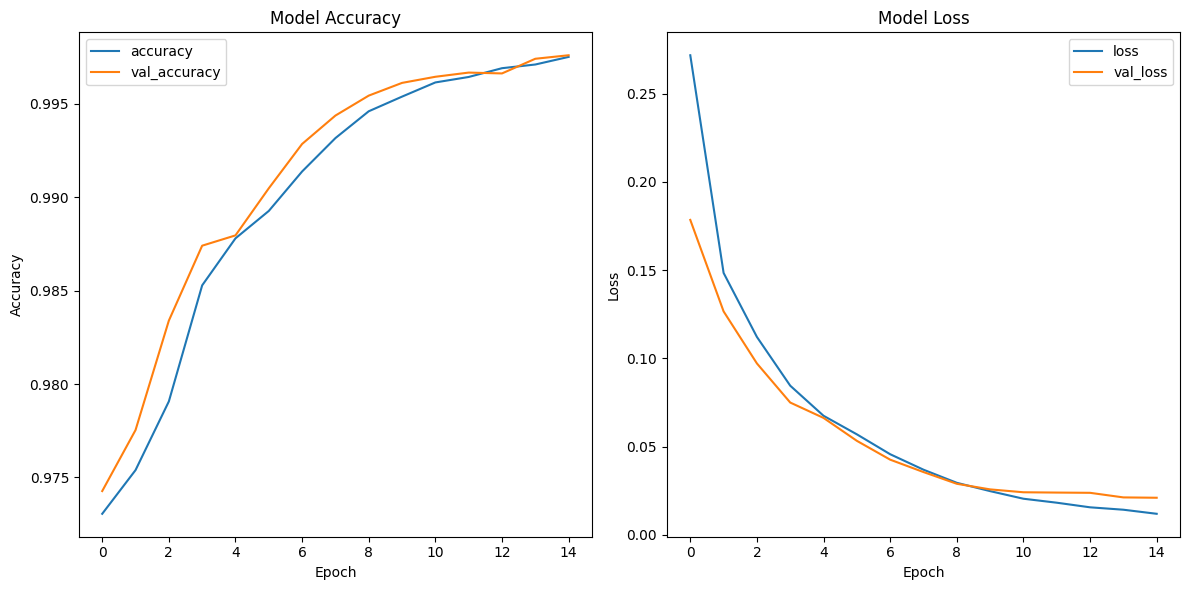

In [7]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
# from rouge import Rouge
import numpy as np

# Fungsi untuk mendekode sequence token menjadi teks
def decode_sequence(sequence, tokenizer):
    words = [tokenizer.index_word[idx] for idx in sequence if idx > 0]  # Hindari token 0 (padding)
    return ' '.join(words)

# Tambahkan token khusus ke tokenizer jika belum ada
if '<start>' not in tokenizer_summary.word_index:
    tokenizer_summary.fit_on_texts(['<start> <end>'])

# Pastikan indeks token khusus tersedia
start_token = tokenizer_summary.word_index.get('<start>', 1)  # Default ke 1 jika tidak ditemukan
end_token = tokenizer_summary.word_index.get('<end>', 2)  # Default ke 2 jika tidak ditemukan

# Dekode prediksi dan referensi
# Inisialisasi input decoder dengan token <start> untuk prediksi awal
decoder_input = np.zeros((len(X_test), max_summary_len))
decoder_input[:, 0] = start_token  # Semua baris dimulai dengan token <start>

# Prediksi dari model
predictions = model.predict([X_test[:5], decoder_input[:5]])

# Dekode prediksi dan referensi
decoded_predictions = []
decoded_references = []

for i in range(len(predictions)):
    pred_tokens = predictions[i].argmax(axis=-1)
    ref_tokens = y_test[i]

    # Decode prediksi dan referensi
    decoded_predictions.append(decode_sequence(pred_tokens, tokenizer_summary))
    decoded_references.append(decode_sequence(ref_tokens, tokenizer_summary))

# Tokenisasi hasil prediksi dan referensi untuk evaluasi
tokenized_predictions = [pred.split() for pred in decoded_predictions]
tokenized_references = [ref.split() for ref in decoded_references]

# Evaluasi dengan BLEU
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smoothing_function = SmoothingFunction().method1
bleu_scores = [
    sentence_bleu([ref], pred, smoothing_function=smoothing_function)
    for ref, pred in zip(tokenized_references, tokenized_predictions)
]
avg_bleu_score = np.mean(bleu_scores)
print(f"Average BLEU score: {avg_bleu_score}")

for i, (input_seq, pred, ref, score) in enumerate(zip(X_test, decoded_predictions, decoded_references, bleu_scores)):
    # Decode input sequence
    input_text = decode_sequence(input_seq, tokenizer_text)
    print(f"Input: {input_text}")
    print(f"Reference: {ref}")
    print(f"Prediction: {pred}")
    print(f"BLEU Score: {score:.4f}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Average BLEU score: 0.00030889142750948706
Input: apa aplikasi musik terbaik untuk ios di mana anda tidak memerlukan internet
Reference: apa aplikasi musik terbaik yang tidak memerlukan wifi untuk ios
Prediction: apa
BLEU Score: 0.0000
--------------------------------------------------
Input: bagaimana anda bisa membedakan antara intp dan intj
Reference: apa perbedaan antara pemborosan dan fc
Prediction: apa
BLEU Score: 0.0012
--------------------------------------------------
Input: bagaimana saya harus memulai dengan pembelajaran mesin
Reference: apa cara biasa untuk mulai belajar pembelajaran mesin
Prediction: apa
BLEU Score: 0.0002
--------------------------------------------------
Input: bagaimana donald trump pilihan yang lebih baik daripada hillary clinton
Reference: akan padamu donald trump menjadi presiden yang lebih baik daripada hillary clinton
Prediction: apa
BLEU Score: 0.0000
--------------------------------------------------
Input: b